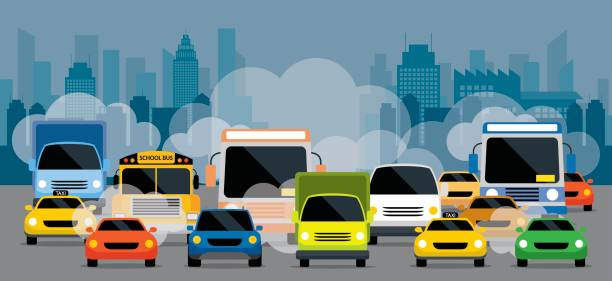

# New York City Taxi Fare Prediction

## Overview
This Notebook will be completed in two main ways.
First, find and visualize useful data or meaningful relationships within the data.
Second, select a model based on the visualization of the previous process. Transform or refine the data into the appropriate form for the model to be used.
<br/><br/>

This is a competition to predict taxi fares in New York. given data contains latitude and longitude. We will predict the result through the boarding position and the disembarkation position. In addition, you can make additional predictions considering the boarding time or boarding date.We need to get New York's latitude and longitude, and remove other values.


##### "In this notebook, New York's longitude and latitude are designated as (40.489707, -74.262378) => (40.937760, -73.698009)"
<br/><br/>

#### My opinion :
1) These data can be visualized as coordinates. So I'm going to visualize where I get in and where I get off a taxi, and then I'm going to visualize a map of New York.<br/>
2) Since taxi time and cost vary from day to day, I think it is better to consider the day of the boarding date to learn about it. ex) Mon, Tue, Wed...

***
## My workflow
#### 1. Import & Install libray
* Import basic libray
* Import Enginnering libray

#### 2. Check out my data
* Check Shape / Info / Describe

#### 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the null values
* Get "Total Distance" Columns (Useing haversine libaray) and Plot it
* Plot the each rows year
* Plot the longitude and latitude per total_distance with [3d interactive Plot]
* Plot the each columns Histogram / Boxplot / Kdeplot


#### 4. Prepocessing Data
* Processing Outlier Values (Out of New York's longitude and latitude)
* In this notebook, New York's longitude and latitude are designated as (40.489707, -74.262378) => (40.937760, -73.698009)

#### 5. Visualization [After Preprocessing]
* Plot the longitude and latitude per total_distance with [3d interactive Plot]
* Plot New York's longitude and latitude against the backdrop of the New York map.

#### 6. Feature Enginnering
* Encoding to Datetime type columns
* Drop unuseful columns

#### 7. Modeling
* * LightGBM Regressor Modeling

#### 8. Submission
* Submit the predictions

# 1. Import & Install libray
* Import basic libray
* Import Enginnering libray
* Install "haversine" libray that, a function to find the distance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline

In [2]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [3]:
from haversine import haversine

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [4]:
train_df = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows= 50000, parse_dates=["pickup_datetime"])
test_df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv', parse_dates=["pickup_datetime"])
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


# 2. Check out my data
* Check Shape / Info / Describe

In [5]:
train_df.shape

(50000, 8)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                50000 non-null  object             
 1   fare_amount        50000 non-null  float64            
 2   pickup_datetime    50000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   50000 non-null  float64            
 4   pickup_latitude    50000 non-null  float64            
 5   dropoff_longitude  50000 non-null  float64            
 6   dropoff_latitude   50000 non-null  float64            
 7   passenger_count    50000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 3.1+ MB


In [7]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734371,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


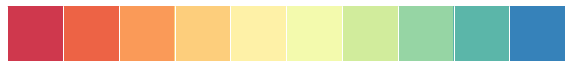

In [8]:
Spectral_palette = sns.color_palette("Spectral", 10)
sns.palplot(Spectral_palette)

# 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the null values
* Get "Total Distance" Columns (Useing haversine libaray) and Plot it
* Plot the each rows year
* Plot the longitude and latitude per total_distance with [3d interactive Plot]
* Plot the each columns Histogram / Boxplot / Kdeplot

### 3-1) Plot the null values


In [9]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


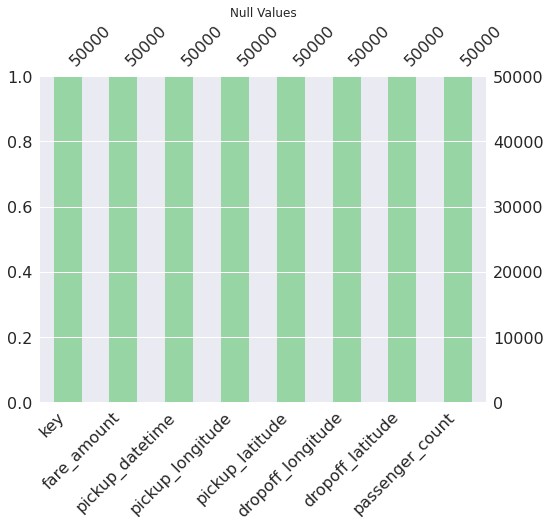

In [10]:
f, ax = plt.subplots(1,1, figsize=(8,6))
msno.bar(train_df, ax=ax, color=Spectral_palette[7])
plt.title('Null Values')
plt.show()

In [11]:
pd.DataFrame(train_df.isnull().sum(), columns=["Train Null Count"])

,Train Null Count
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [12]:
pd.DataFrame(test_df.isnull().sum(), columns=["Test Null Count"])

,Test Null Count
key,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [13]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


### 3-2)  Get "Total Distance" Columns (Useing haversine libaray) and Plot it

In [14]:
def get_total_distance(df):
    a1 = df['pickup_latitude']
    a2 = df['dropoff_latitude']
    
    b1 = df['pickup_longitude']
    b2 = df['dropoff_longitude']

    pick_up = (a1, b1) 
    drop_off = (a2, b2)
    return haversine(pick_up, drop_off)
    # haversine function : Get Distance to use x(latitude, longitude), y(latitude, longitude)

-> When you need Total Distance, Then you can use this function

In [15]:
train_df['total_distance'] = train_df.apply(lambda x: get_total_distance(x),axis=1)
test_df['total_distance'] = test_df.apply(lambda x: get_total_distance(x),axis=1)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030765
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450145
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389527
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799274
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999160


In [16]:
Spectral_palette

[(0.8141484044598232, 0.2196847366397539, 0.3048058439061899),
 (0.9330257593233372, 0.3913110342176086, 0.27197231833910035),
 (0.9817762399077278, 0.6073817762399076, 0.3457900807381776),
 (0.9946943483275663, 0.8092272202998846, 0.48696655132641287),
 (0.9982314494425221, 0.9451749327181853, 0.6570549788542868),
 (0.9557862360630527, 0.9823144944252211, 0.6800461361014996),
 (0.8202998846597465, 0.9275663206459055, 0.6126874279123413),
 (0.5910034602076126, 0.835524798154556, 0.6442906574394464),
 (0.3600153787004998, 0.7161860822760476, 0.6655132641291811),
 (0.21299500192233756, 0.5114186851211072, 0.730795847750865)]

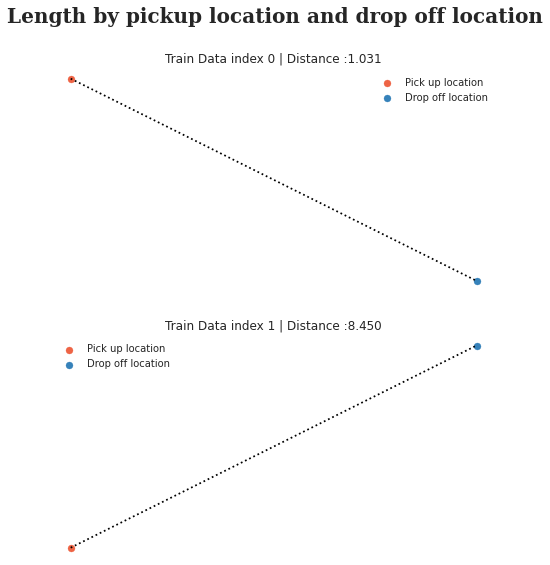

In [17]:
fig = plt.figure(figsize=(8,9))

for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.title("Train Data index {} | Distance :{:.3f}".format(i, train_df['total_distance'][i]))
    plt.scatter(train_df['pickup_longitude'][i], train_df['pickup_latitude'][i], color=Spectral_palette[1], label="Pick up location")
    plt.scatter(train_df['dropoff_longitude'][i], train_df['dropoff_latitude'][i], color=Spectral_palette[-1], label="Drop off location")
    plt.plot([train_df['pickup_longitude'][i],train_df['dropoff_longitude'][i]],[train_df['pickup_latitude'][i],train_df['dropoff_latitude'][i]],'k:')
    plt.axis('off')
    plt.legend()
    
fig.text(0.05,0.95,"Length by pickup location and drop off location", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

### 3-3) Plot the longitude and latitude per total_distance with [3d interactive Plot]

* (pickup_longitude, dropoff_longitude) per fare_amount

In [18]:
f = px.scatter_3d(train_df[:10000], x='pickup_latitude', y='pickup_longitude', z='total_distance',
                    color='fare_amount')
f.show()

In [19]:
f = px.scatter_3d(train_df[:10000], x='dropoff_latitude', y='dropoff_longitude', z='total_distance',
                    color='fare_amount')
f.show()

#### => Looking at the graph above, no significant results can be found. <br/> So after the preprocessing process, I plan to visualize it again.

### 3-4) Plot the each rows year

In [20]:
train_df['pickup_datetime_year'] = train_df['pickup_datetime'].dt.year
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,pickup_datetime_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030765,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450145,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389527,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799274,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999160,2010


In [21]:
train_df['pickup_datetime_year'].value_counts()

2012    8005
2011    7832
2013    7819
2009    7716
2010    7646
2014    7530
2015    3452
Name: pickup_datetime_year, dtype: int64

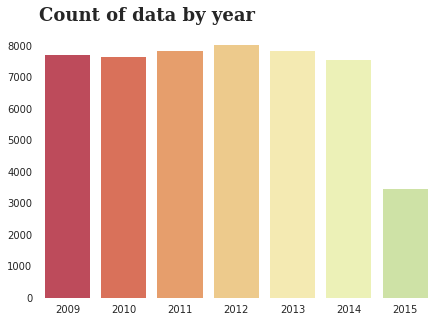

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6, 4), constrained_layout=True)

ax = sns.countplot(train_df['pickup_datetime_year'], palette=Spectral_palette)
ax.patch.set_alpha(0)
ax.set_xlabel("")
ax.set_ylabel("")
fig.text(0.08,1.03,"Count of data by year", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

### 3-5) Plot the each columns Histogram / Boxplot / Kdeplot

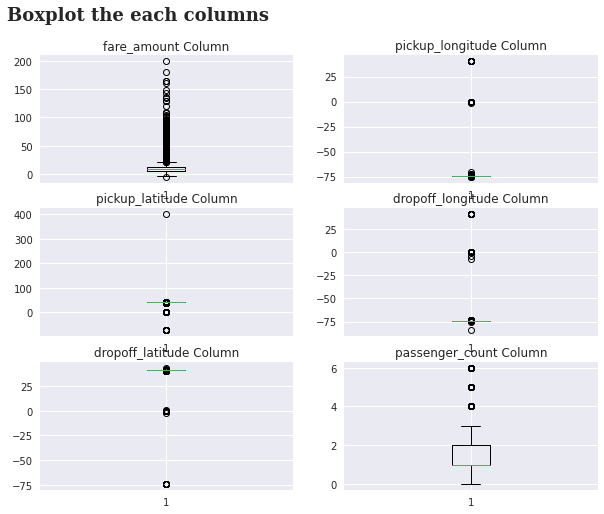

In [23]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(10,8))

for num, i in enumerate(df_index):
    plt.subplot(3,2,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    plt.boxplot(train_df.iloc[:,i])

fig.text(0.08,0.94,"Boxplot the each columns", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

Spectral_palette

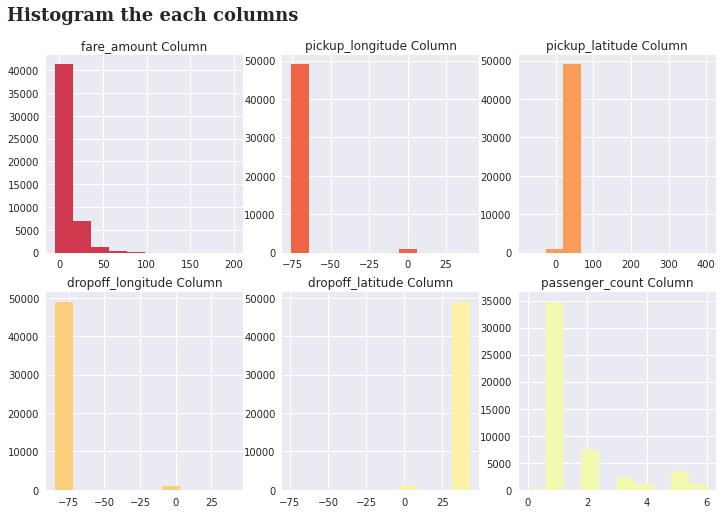

In [24]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(12,8))

for num, i in enumerate(df_index):
    plt.subplot(2, 3,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    plt.hist(train_df.iloc[:,i], color=Spectral_palette[num])

fig.text(0.08,0.94,"Histogram the each columns", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

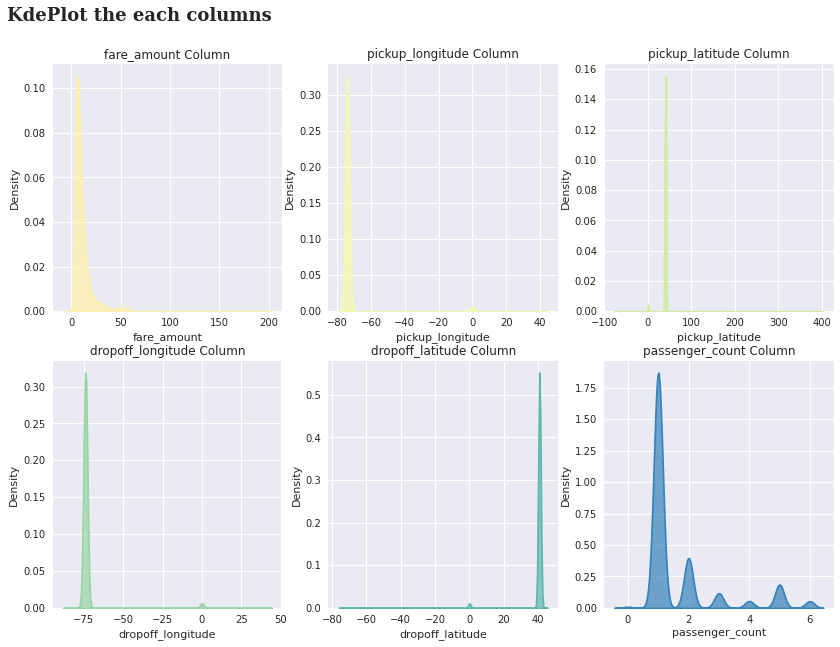

In [25]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(14,10))

for num, i in enumerate(df_index):
    plt.subplot(2,3,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    sns.kdeplot(train_df.iloc[:,i], fill=True, lw=1.7, alpha=0.7, color=Spectral_palette[num+4])

fig.text(0.08,0.94,"KdePlot the each columns", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

# 4. Prepocessing Data
* Processing Outlier Values (Out of New York's longitude and latitude)

=>In this notebook, New York's longitude and latitude are designated as (40.489707, -74.262378) => (40.937760, -73.698009)

##### About New York's latitude / longitude <br/>
* latitude  	40°29'40"N - 45°0'42"N (~40.6643)
* longitude 	71°47'25"W - 79°45'54"W (~-73.9385)
* This notebook will use (latitude, longitude) / (40.489707, -74.262378) => (40.937760, -73.698009)

### 4-1) Processing Outlier Values

In [26]:
def data_cleansing(df, data="Train"):
    
    print("Before cleansing shape : {}".format(df.shape))
    print("----- CLEANSING -----")
    
    if data=="Train":
        df = df.drop(df[df['fare_amount'] <= 2].index)
        df = df.drop(df[df['fare_amount'] >= 100].index)
        print(df.shape)
    
    df = df.drop(df[df['pickup_longitude'] <= -74.5].index)
    df = df.drop(df[df['pickup_longitude'] >= -73.5].index)
    print(df.shape)
   
    df = df.drop(df[df['pickup_latitude'] <= 40.4].index)
    df = df.drop(df[df['pickup_latitude'] >= 41].index)
    print(df.shape)
   
    df = df.drop(df[df['dropoff_longitude'] <= -74.5].index)
    df = df.drop(df[df['dropoff_longitude'] >= -73.5].index)
    print(df.shape)
   
    df = df.drop(df[df['dropoff_latitude'] <= 40.4].index)
    df = df.drop(df[df['dropoff_latitude'] >= 41].index)
    print(df.shape)
       
    # No more than 7 passengers are allowed on board.
    df = df.drop(df[df['passenger_count'] <= 0].index)
    df = df.drop(df[df['passenger_count'] >= 7].index)
    
    print("----- CLEANSING -----")
    print("After cleansing shape : {}".format(df.shape))
    
    return df

In [27]:
train_df['fare_amount'].sort_values(ascending=False)

28373    200.0
1335     180.0
1483     165.0
43956    165.0
46198    160.0
         ...  
2486      -2.5
28839     -2.5
2039      -2.9
13032     -3.0
42337     -5.0
Name: fare_amount, Length: 50000, dtype: float64

In [28]:
train_df = data_cleansing(train_df, "Train")

Before cleansing shape : (50000, 10)
----- CLEANSING -----
(49972, 10)
(48964, 10)
(48944, 10)
(48895, 10)
(48889, 10)
----- CLEANSING -----
After cleansing shape : (48730, 10)


# 5. EDA with Visualization [After Preprocessing]
* Plot the longitude and latitude per total_distance with [3d interactive Plot]
* Plot New York's longitude and latitude against the backdrop of the New York map.

### 5-1) Plot the longitude and latitude per total_distance with [3d interactive Plot]

In [29]:
f = px.scatter_3d(train_df[:10000], x='pickup_latitude', y='pickup_longitude', z='total_distance',
                    color='fare_amount')
f.show()

In [30]:
f = px.scatter_3d(train_df[:10000], x='dropoff_latitude', y='dropoff_longitude', z='total_distance',
                    color='fare_amount')
f.show()

In [31]:
map_img = plt.imread('../input/google-map-nyc-40474541735-kor-version/google_map_NYC_(40.4-74.541-73.5)_KOR_VERSION.png')

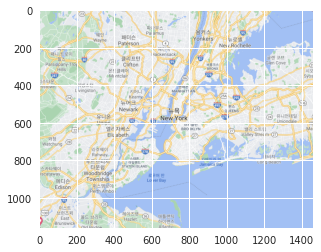

In [32]:
plt.imshow(map_img)
plt.show()

### 5-2) Plot New York's longitude and latitude against the backdrop of the New York map.
##### You can use this img
* Add data => Search the "google_mapNYC(40.4-74.541-73.5)_KOR_VERSION.png"

In [33]:
def plot_map(df, map_img, s=10, alpha=0.2):
    f, ax = plt.subplots(1, 2, figsize=(16,8))
    ax[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    ax[0].set_xlim(-74.5, -73.5)
    ax[0].set_ylim((40.4, 41))
    ax[0].set_title('Pickup locations')
    ax[0].axis('off')
    ax[0].imshow(map_img, zorder=0, extent=(-74.5, -73.5, 40.4, 41))

    ax[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    ax[1].set_xlim(-74.5, -73.5)
    ax[1].set_ylim((40.4, 41))
    ax[1].set_title('Dropoff locations')
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    ax[1].imshow(map_img, zorder=0, extent=(-74.5, -73.5, 40.4, 41))

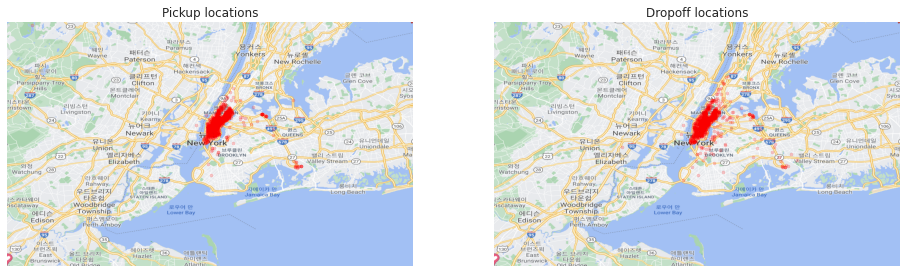

In [34]:
plot_map(train_df[:1000], map_img)

# 6. Feature Enginnering
* Encoding to Datetime type columns
* Drop unuseful columns

In [35]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,pickup_datetime_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030765,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450145,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389527,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799274,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999160,2010


### 6-1) Encoding to Datetime type columns

In [36]:
train_df["year"] = train_df["pickup_datetime"].dt.year
train_df["weekday"] = train_df["pickup_datetime"].dt.weekday
train_df["hour"] = train_df["pickup_datetime"].dt.hour

test_df["year"] = test_df["pickup_datetime"].dt.year
test_df["weekday"] = test_df["pickup_datetime"].dt.weekday
test_df["hour"] = test_df["pickup_datetime"].dt.hour

In [37]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,pickup_datetime_year,year,weekday,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030765,2009,2009,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450145,2010,2010,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389527,2011,2011,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799274,2012,2012,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999160,2010,2010,1,7


In [38]:
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,year,weekday,hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2.323263,2015,1,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2.425356,2015,1,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,0.618629,2011,5,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,1.961035,2012,5,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,5.387309,2012,5,21


### 6-2) Drop useful Columns

In [39]:
train_df.drop(['key','pickup_datetime','pickup_datetime_year'], axis=1, inplace=True)
test_df.drop(['key','pickup_datetime'], axis=1, inplace=True)
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,year,weekday,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1.030765,2009,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,8.450145,2010,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,1.389527,2011,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2.799274,2012,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1.999160,2010,1,7


In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48730 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        48730 non-null  float64
 1   pickup_longitude   48730 non-null  float64
 2   pickup_latitude    48730 non-null  float64
 3   dropoff_longitude  48730 non-null  float64
 4   dropoff_latitude   48730 non-null  float64
 5   passenger_count    48730 non-null  int64  
 6   total_distance     48730 non-null  float64
 7   year               48730 non-null  int64  
 8   weekday            48730 non-null  int64  
 9   hour               48730 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 5.1 MB


# 7. Modeling
* LightGBM Regressor Modeling
* Divide the data into training, testing and evaluation
* Training
* Evaluating

### 7-1) Divide the data into training, testing and evaluation

In [41]:
x = train_df.drop('fare_amount', axis=1)
y = train_df['fare_amount']

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("X train data shape : {}".format(x_train.shape))
print("Y train data shape : {}".format(y_train.shape))

print("X test data shape : {}".format(x_test.shape))
print("Y test data shape : {}".format(y_test.shape))

X train data shape : (34111, 9)
Y train data shape : (34111,)
X test data shape : (14619, 9)
Y test data shape : (14619,)


In [43]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.6)
print("X validation data shape : {}".format(x_val.shape))
print("Y validation data shape : {}".format(y_val.shape))

print("X test data shape : {}".format(x_test.shape))
print("Y test data shape : {}".format(y_test.shape))

X validation data shape : (8772, 9)
Y validation data shape : (8772,)
X test data shape : (5847, 9)
Y test data shape : (5847,)


#### - Lgbm Regressor

### 7-2) Training

In [44]:
train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val)

In [45]:
params = {
    'n_estimators': 5000,
    'num_leaves': 500,
    'max_depth': -1,
    'min_data_in_leaf': 1000,
    'learning_rate': 0.003,
    'boosting': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'Is_training_metric': True,
    'n_jobs': -1
}

In [46]:
model = lgb.train(params,
                  train_data,
                  valid_sets=val_data, 
                  valid_names=['train','valid'],
                  early_stopping_rounds=100)

[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1321
[LightGBM] [Info] Number of data points in the train set: 34111, number of used features: 9
[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Info] Start training from score 11.333325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's l2: 84.2477
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's l2: 83.8569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's l2: 83.4685
[LightGBM] [Warning] No further splits with positive ga

### 7-3) Evaluating

In [47]:
print('Starting predicting...')
# predict
y_pred = model.predict(x_test)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred))

Starting predicting...
The rmse of prediction is: 16.48972416073335


# 8. Submission
* Submit the predictions

In [48]:
submission = pd.read_csv('../input/new-york-city-taxi-fare-prediction/sample_submission.csv')
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [49]:
submission.shape

(9914, 2)

In [50]:
pred = model.predict(test_df)

In [51]:
print(pred[:10])

[10.52253174 11.52172501  4.7244741   7.787998   13.1556363   9.2475806
  5.05107401 47.16172961 11.80261337  6.90863499]


In [52]:
submission['fare_amount'] = pred

In [53]:
submission.to_csv("submission.csv", index=False)

##### Reference
* https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration
* http://egloos.zum.com/incredible/v/7479081

###  If this notebook is useful for your kaggling, "UPVOTE" for it 👀
#### THX to Reading My Notebook🌈